In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from datetime import timedelta
from collections import Counter
import tensorflow.contrib.keras as kr
import jieba as jb
from sklearn import metrics
import matplotlib.pyplot as plt

# 指定GPU编号
os.environ["CUDA_VISIBLE_DEVICES"]="7"  

/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
# only one start
def build_word2id(file):
    """
    :param file: word2id保存地址
    :return: None
    """
    word2id = {'_PAD_': 0}
    path = ['./data/train.txt', './data/validation.txt']
    print(path)
    for _path in path:
        with open(_path, encoding='utf-8') as f:
            for line in f.readlines():
                sp = line.strip().split()
                for word in sp[1:]:
                    if word not in word2id.keys():
                        word2id[word] = len(word2id)

    with open(file, 'w', encoding='utf-8') as f:
        for w in word2id:
            f.write(w+'\t')
            f.write(str(word2id[w]))
            f.write('\n')

In [ ]:
# 保存
# build_word2id('./data/word_to_id.txt')

In [2]:
def load_word2id(path):
    """
    :param path: word_to_id词汇表路径
    :return: word_to_id:{word: id}
    """
    word_to_id = {}
    with open(path, encoding='utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            word = sp[0]
            idx = int(sp[1])
            if word not in word_to_id:
                word_to_id[word] = idx
    return word_to_id

In [3]:
# 加载
word2id = load_word2id('./data/word_to_id.txt')

In [ ]:
def build_word2vec(fname, word2id, save_to_path=None):
    """
    :param fname: 预训练的word2vec.
    :param word2id: 语料文本中包含的词汇集.
    :param save_to_path: 保存训练语料库中的词组对应的word2vec到本地
    :return: 语料文本中词汇集对应的word2vec向量{id: word2vec}.
    """
    import gensim
    n_words = max(word2id.values()) + 1
    model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)
    word_vecs = np.array(np.random.uniform(-1., 1., [n_words, model.vector_size]))
    for word in word2id.keys():
        try:
            word_vecs[word2id[word]] = model[word]
        except KeyError:
            pass
    if save_to_path:
        with open(save_to_path, 'w', encoding='utf-8') as f:
            for vec in word_vecs:
                vec = [str(w) for w in vec]
                f.write(' '.join(vec))
                f.write('\n')
    return word_vecs

In [ ]:
# w2v = build_word2vec('./data/wiki_word2vec_50.bin', word2id, save_to_path='./data/corpus_word2vec.txt')

In [4]:
def cat_to_id(classes=None):
    """
    :param classes: 分类标签；默认为0--pos   1--neg
    :return: {分类标签：id}
    """
    if not classes:
        classes = ['0', '1']
    cat2id = {cat: idx for (idx, cat) in enumerate(classes)}
    return classes, cat2id

In [5]:
def load_corpus(path, word2id, max_sen_len=70):
    """
    :param path: 样本语料库的文件
    :return: 文本内容contents，以及分类标签labels(onehot形式)
    """
    _, cat2id = cat_to_id()
    contents, labels = [], []
    with open(path, encoding='utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            label = sp[0]
            content = [word2id.get(w, 0) for w in sp[1:]]
            content = content[:max_sen_len]
            if len(content) < max_sen_len:
                content += [word2id['_PAD_']] * (max_sen_len - len(content))
            labels.append(label)
            contents.append(content)
    counter = Counter(labels)
    print('总样本数为：%d' % (len(labels)))
    print('各个类别样本数如下：')
    for w in counter:
        print(w, counter[w])

    contents = np.asarray(contents)
    labels = [cat2id[l] for l in labels]
    labels = kr.utils.to_categorical(labels, len(cat2id))

    return contents, labels

In [6]:
def load_corpus_word2vec(path):
    """加载语料库word2vec词向量,相对wiki词向量相对较小"""
    word2vec = []
    with open(path, encoding='utf-8') as f:
        for line in f.readlines():
            sp = [float(w) for w in line.strip().split()]
            word2vec.append(sp)
    return np.asarray(word2vec)

In [7]:
word2vec = load_corpus_word2vec('./data/corpus_word2vec.txt')

In [9]:
def time_diff(start_time):
    """当前距初始时间已花费的时间"""
    end_time = time.time()
    diff = end_time - start_time
    return timedelta(seconds=int(round(diff)))

In [10]:
def batch_index(length, batch_size, is_shuffle=True):
    """
    生成批处理样本序列id.
    :param length: 样本总数
    :param batch_size: 批处理大小
    :param is_shuffle: 是否打乱样本顺序
    :return:
    """
    index = [idx for idx in range(length)]
    if is_shuffle:
        np.random.shuffle(index)
    for i in range(int(np.ceil(length / batch_size))):
        yield index[i * batch_size:(i + 1) * batch_size]

In [11]:
# 配置模型参数
class CONFIG():
    update_w2v = True           # 是否在训练中更新w2v
    vocab_size = 59290          # 词汇量，与word2id中的词汇量一致
    n_class = 2                 # 分类数：分别为pos和neg
    max_sen_len = 80            # 句子最大长度
    embedding_dim = 50          # 词向量维度
    batch_size = 100            # 批处理尺寸
    n_hidden = 256              # 隐藏层节点数
    n_epoch = 10                # 训练迭代周期，即遍历整个训练样本的次数
    opt = 'adam'                # 训练优化器：adam或者adadelta
    learning_rate = 0.001       # 学习率；若opt=‘adadelta'，则不需要定义学习率
    drop_keep_prob = 0.5        # dropout层，参数keep的比例
    num_filters = 256           # 卷积层filter的数量
    kernel_size = 3            # 卷积核的尺寸；nlp任务中通常选择2,3,4,5
    print_per_batch = 100       # 训练过程中,每100词batch迭代，打印训练信息
    save_dir = './checkpoints/' # 训练模型保存的地址
    train_path = './data/train.txt'
    dev_path = './data/validation.txt'
    test_path = './data/test.txt'
    word2id_path = './data/word_to_id.txt'
    pre_word2vec_path = './data/wiki_word2vec_50.bin'
    corpus_word2vec_path = './data/corpus_word2vec.txt'

In [15]:
# 建立Text-CNN模型
class TextCNN(object):
    def __init__(self, config, embeddings=None):
        # 加载相关配置
        self.update_w2v = config.update_w2v
        self.vocab_size = config.vocab_size
        self.n_class = config.n_class
        self.max_sen_len= config.max_sen_len
        self.embedding_dim = config.embedding_dim
        self.batch_size = config.batch_size
        self.num_filters = config.num_filters
        self.kernel_size = config.kernel_size
        self.n_hidden = config.n_hidden
        self.n_epoch = config.n_epoch
        self.opt = config.opt
        self.learning_rate = config.learning_rate
        self.drop_keep_prob = config.drop_keep_prob

        self.x = tf.placeholder(tf.int32, [None, self.max_sen_len], name='x')
        self.y = tf.placeholder(tf.int32, [None, self.n_class], name='y')
        if embeddings is not None:
            self.word_embeddings = tf.Variable(embeddings, dtype=tf.float32, trainable=self.update_w2v)
        else:
            self.word_embeddings = tf.Variable(
                tf.zeros([self.vocab_size, self.embedding_dim]),
                dtype=tf.float32,
                trainable=self.update_w2v)

        self.build()

    def cnn(self):
        """
        :param mode:默认为None，主要调节dropout操作对训练和预测带来的差异。
        :return: 未经softmax变换的fully-connected输出结果
        """
        inputs = self.add_embeddings()
        with tf.name_scope("cnn"):
            # CNN layer
            conv = tf.layers.conv1d(inputs, self.num_filters, self.kernel_size, name='conv')
            # global max pooling layer
            gmp = tf.reduce_max(conv, reduction_indices=[1], name='gmp')
            # dropout 卷积层后加dropout效果太差
            # gmp = tf.contrib.layers.dropout(gmp, self.drop_keep_prob)

        with tf.name_scope("score"):
            # fully-connected
            fc = tf.layers.dense(gmp, self.n_hidden, name='fc1')
            # dropout 
            fc = tf.contrib.layers.dropout(fc, self.drop_keep_prob)
            # nonlinear
            fc = tf.nn.relu(fc)
            # fully-connected
            pred = tf.layers.dense(fc, self.n_class, name='fc2')
        return pred

    def add_embeddings(self):
        inputs = tf.nn.embedding_lookup(self.word_embeddings, self.x)
        return inputs

    def add_loss(self, pred):
        cost = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=self.y)
        cost = tf.reduce_mean(cost)
        return cost

    def add_optimizer(self, loss):
        if self.opt == 'adadelta':
            optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0, rho=0.95, epsilon=1e-6)
        else:
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
        opt = optimizer.minimize(loss)
        return opt

    def add_accuracy(self, pred):
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        return accuracy

    def get_batches(self, x, y=None, batch_size=100, is_shuffle=True):
        for index in batch_index(len(x), batch_size, is_shuffle=is_shuffle):
            n = len(index)
            feed_dict = {
                self.x: x[index]
            }
            if y is not None:
                feed_dict[self.y] = y[index]
            yield feed_dict, n

    def build(self):
        self.pred = self.cnn()
        self.loss = self.add_loss(self.pred)
        self.accuracy = self.add_accuracy(self.pred)
        self.optimizer = self.add_optimizer(self.loss)

    def train_on_batch(self, sess, feed):
        _, _loss, _acc = sess.run([self.optimizer, self.loss, self.accuracy], feed_dict=feed)
        return _loss, _acc

    def test_on_batch(self, sess, feed):
        _loss, _acc = sess.run([self.loss, self.accuracy], feed_dict=feed)
        return _loss, _acc

    def predict_on_batch(self, sess, feed, prob=True):
        result = tf.argmax(self.pred, 1)
        if prob:
            result = tf.nn.softmax(logits=self.pred, dim=1)

        res = sess.run(result, feed_dict=feed)
        return res

    def predict(self, sess, x, prob=False):
        yhat = []
        for _feed, _ in self.get_batches(x, batch_size=self.batch_size, is_shuffle=False):
            _yhat = self.predict_on_batch(sess, _feed, prob)
            yhat += _yhat.tolist()
            # yhat.append(_yhat)
        return np.array(yhat)

    def evaluate(self, sess, x, y):
        """评估在某一数据集上的准确率和损失"""
        num = len(x)
        total_loss, total_acc = 0., 0.
        for _feed, _n in self.get_batches(x, y, batch_size=self.batch_size):
            loss, acc = self.test_on_batch(sess, _feed)
            total_loss += loss * _n
            total_acc += acc * _n
        return total_loss / num, total_acc / num

    def fit(self, sess, x_train, y_train, x_dev, y_dev, save_dir=None, print_per_batch=100):
        saver = tf.train.Saver()
        if save_dir:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        sess.run(tf.global_variables_initializer())

        print('Training and evaluating...')
        # 存储准确率
        cnn_train_accuracy = []
        cnn_val_accuracy = []
        start_time = time.time()
        total_batch = 0 # 总批次
        best_acc_dev = 0.0  # 最佳验证集准确率
        last_improved = 0   # 记录上次提升批次
        require_improvement = 500  # 如果超过500轮模型效果未提升，提前结束训练
        flags = False
        for epoch in range(self.n_epoch):
            print('Epoch:', epoch + 1)
            for train_feed, train_n in self.get_batches(x_train, y_train, batch_size=self.batch_size):
                loss_train, acc_train = self.train_on_batch(sess, train_feed)
                loss_dev, acc_dev = self.evaluate(sess, x_dev, y_dev)
                if total_batch % print_per_batch == 0:
                    if acc_dev > best_acc_dev:
                        # 保存在验证集上性能最好的模型
                        best_acc_dev = acc_dev
                        last_improved = total_batch
                        if save_dir:
                            saver.save(sess=sess, save_path=os.path.join(save_dir, 'sa-model'))
                        improved_str = '*'
                    else:
                        improved_str = ''

                    time_dif = time_diff(start_time)
                    msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%},' + \
                          ' Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}, Time: {5} {6}'
                    cnn_train_accuracy.append(acc_train)
                    cnn_val_accuracy.append(acc_dev)
                    print(msg.format(total_batch, loss_train, acc_train, loss_dev, acc_dev, time_dif, improved_str))
                total_batch += 1
                
                if total_batch - last_improved > require_improvement:
                    print('No optimization for a long time, auto-stopping...')
                    flags = True
                    break
            if flags:
                break
        plt.plot(cnn_train_accuracy)
        plt.plot(cnn_val_accuracy)
        plt.ylim(ymin=0.5, ymax=1.01)
        plt.title("The accuracy of CNN model") 
        plt.legend(["train", "val"])

In [16]:
# 模型训练与验证
def train():
    config = CONFIG()
    print('========================加载word2id===========================')
    word2id = load_word2id(config.word2id_path)
    print('========================加载word2vec==========================')
    word2vec = load_corpus_word2vec(config.corpus_word2vec_path)
    print('========================加载train语料库========================')
    x_tr, y_tr = load_corpus(config.train_path, word2id, max_sen_len=config.max_sen_len)
    print('========================加载Validation语料库==========================')
    x_val, y_val = load_corpus(config.dev_path, word2id, max_sen_len=config.max_sen_len)
    print('========================训练模型===============================')
    tc = TextCNN(CONFIG, embeddings=word2vec)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        tc.fit(sess, x_tr, y_tr, x_val, y_val, config.save_dir, config.print_per_batch)

========================加载word2id===========================
========================加载word2vec==========================
========================加载train语料库========================
总样本数为：19998
各个类别样本数如下：
1 9999
0 9999
========================加载Validation语料库==========================
总样本数为：5998
各个类别样本数如下：
1 2999
0 2999
========================训练模型===============================
Training and evaluating...
Epoch: 1
Iter:      0, Train Loss:   0.93, Train Acc:  53.00%, Val Loss:   0.85, Val Acc:  49.42%, Time: 0:00:00 *
Iter:    100, Train Loss:    0.5, Train Acc:  71.00%, Val Loss:   0.51, Val Acc:  74.44%, Time: 0:00:19 *
Epoch: 2
Iter:    200, Train Loss:   0.39, Train Acc:  86.00%, Val Loss:   0.45, Val Acc:  78.76%, Time: 0:00:38 *
Iter:    300, Train Loss:   0.34, Train Acc:  85.00%, Val Loss:   0.42, Val Acc:  80.89%, Time: 0:00:54 *
Epoch: 3
Iter:    400, Train Loss:   0.37, Train Acc:  83.00%, Val Loss:   0.41, Val Acc:  81.08%, Time: 0:01:12 *
Iter:    500, Train Loss:   0.21, Tr

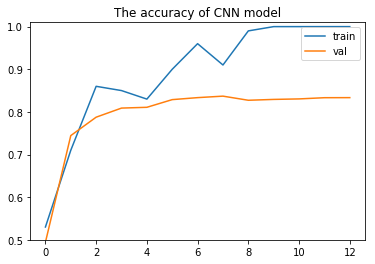

In [17]:
# clear graph
tf.reset_default_graph()
train()

In [ ]:
# https://github.com/guuboi/SentimentAnalysis

In [18]:
# 模型测试
def test():
    config = CONFIG()
    print('加载word2id===========================')
    word2id = load_word2id(config.word2id_path)
    config.vocab_size = len(word2id)
    print('加载test语料库=========================')
    x, y = load_corpus(config.test_path, word2id, max_sen_len=config.max_sen_len)
    # x, y = x[:10], y[:10]
    model = TextCNN(config)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(config.save_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

        yhat = model.predict(sess, x)

    cat, cat2id = cat_to_id()
    y_cls = np.argmax(y, 1)
    # 评估
    print("Precision, Recall and F1-Score...")
    print(metrics.classification_report(y_cls, yhat, target_names=cat))
    # 混淆矩阵
    print("Confusion Matrix...")
    cm = metrics.confusion_matrix(y_cls, yhat)
    print(cm)

In [19]:
tf.reset_default_graph()
test()

加载word2id===========================
加载test语料库=========================
总样本数为：272
各个类别样本数如下：
1 141
0 131
INFO:tensorflow:Restoring parameters from ./checkpoints/sa-model
Precision, Recall and F1-Score...
             precision    recall  f1-score   support

          0       0.79      0.79      0.79       131
          1       0.80      0.80      0.80       141

avg / total       0.79      0.79      0.79       272

Confusion Matrix...
[[103  28]
 [ 28 113]]


In [20]:
'''
预测

'''

def sent_to_id(inputs):
    """
    将语句进行分词，然后将词语转换为word_to_id中的id编码
    :param inputs: 句子：列表的形式
    :return: 用id表征的语句
    """
    sentences = []
    cut_sents = [jb.cut(w) for w in inputs]
    config = CONFIG()
    word2id = load_word2id(config.word2id_path)

    for cut_sent in cut_sents:
        sentence = [word2id.get(w, 0) for w in cut_sent]
        sentence = sentence[:config.max_sen_len]
        if len(sentence) < config.max_sen_len:
            sentence += [word2id['_PAD_']] * (config.max_sen_len - len(sentence))

        sentences.append(sentence)

    return np.asarray(sentences)

In [21]:
def predict(x, label=False, prob=False):
    """
    :param x: 语句列表
    :param label: 是否以分类标签的形式：posn或eg输出。默认为：0/1
    :param prob: 是否以概率的形式输出。
    :return: 情感预测结果
    """
    if label and prob:
        raise Exception("label和prob两个参数不能同时为True!")

    x = sent_to_id(x)
    config = CONFIG()
    model = TextCNN(config)
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(config.save_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

        y = model.predict(sess, x, prob=prob)

    if label:
        cat, _ = cat_to_id()
        y = [cat[w] for w in y.tolist()]
    return y

In [38]:
# 使用训练所得模型进行电影评论分析 # 0--pos   1--neg
tf.reset_default_graph()
test = ['完成度很高的公路喜剧片，亮点在于人物塑造完整和细节使用精彩，剧作与表演堪称杰出。','爆米花电影，特效不错，可以一看。但也有几处硬伤']
print(predict(test, label=False, prob=True))

INFO:tensorflow:Restoring parameters from ./checkpoints/sa-model
[[0.9986732  0.00132688]
 [0.93199974 0.06800031]]
